<h1>Table of Contents - test<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#get-clean-data" data-toc-modified-id="get-clean-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>get clean data</a></span></li><li><span><a href="#prepare-for-neural-network" data-toc-modified-id="prepare-for-neural-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>prepare for neural network</a></span></li><li><span><a href="#Pre-process-the-embeddings" data-toc-modified-id="Pre-process-the-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-process the embeddings</a></span></li><li><span><a href="#Define-a-model" data-toc-modified-id="Define-a-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define a model</a></span></li><li><span><a href="#predict" data-toc-modified-id="predict-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>predict</a></span></li><li><span><a href="#test" data-toc-modified-id="test-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>test</a></span></li><li><span><a href="#test" data-toc-modified-id="test-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>test</a></span></li></ul></div>

In [1]:
## Pre-setting
# automatically adjust the width of the notebook code cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# if one module is changed, this line will automatically reload that module
%load_ext autoreload
%autoreload 2
# display the figure in the notebook
%matplotlib inline
# To change the font size in acrobat
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
## Add path
import os
import sys
src_dir = os.path.abspath(os.path.join(os.pardir, 'src'))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

In [3]:
import json
import numpy as np
import gensim as gs
from collections import Counter


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss


In [5]:
import pandas as pd

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# import numpy as np

Using TensorFlow backend.


## get clean data

In [7]:
email_6p2_folder = os.path.abspath(os.path.join(os.pardir, 'data', 's2021_lumen_clean_data'))
email_6p2_file = 's2021_06_20_01_lumen_clean_doc_sia_liwc_classify.csv'
email_6p2_location = os.path.join(email_6p2_folder, email_6p2_file)

In [8]:
email_6p2_df = pd.read_csv(email_6p2_location)

In [9]:
doc_list = list(email_6p2_df.nostop_stem_doc)

In [10]:
# 2021-06-30
influence_list = [
    'Authority or Expertise/Source Credibility',
    'Commitment',
    'Commitment- Call to Action',
    'Subjectivity',
    'Gain framing',
    'Blame/guilt',
    'Emphasis',
]

influence_list

['Authority or Expertise/Source Credibility',
 'Commitment',
 'Commitment- Call to Action',
 'Subjectivity',
 'Gain framing',
 'Blame/guilt',
 'Emphasis']

In [11]:
bi_weapon_array = email_6p2_df[influence_list].values.astype(int)

In [12]:
len(doc_list), bi_weapon_array.shape

(2771, (2771, 7))

In [13]:
bi_weapon_array.sum(axis=0)

array([2110, 1461, 1243, 1807,  390,  856,  933])

In [14]:
doc_list[5:8]

['cours want rememb posit thing done last impact make individu peopl two six annual presid leadership award given student cockrel school engin presid leadership award grant black student blackmattersu com blackmattersu com http blackmattersu com presid leadership award grant black student',
 'peopl toler two homosexu see leav togeth next day smile hold hand tenderli embrac one anoth forgiven departur pleasur unaccept wake happi michel foucault philosoph social critic lgbt homophobia foucault societi queerquot',
 'popey fri chicken fantast new yorker food writer helen rosner wrote aug meat flavor juici encas spiki golden sea urchin batter surprisingli light uncommonli crispi right amount cocain least recycl imag recent post facebook would believ imag look like news stori headlin popey manag arrest allegedli dip chicken cocain base flour increas busi sale given recent craze chain new chicken sandwich one might actual believ headlin fake popey nation aug post flag part facebook effort com

In [15]:
doc_length_list = [len(i.split()) for i in doc_list]

In [16]:
np.mean(doc_length_list), np.median(doc_length_list), np.std(doc_length_list), Counter(doc_length_list)

(66.20064958498737,
 66.0,
 25.51259012882596,
 Counter({69: 45,
          99: 22,
          76: 39,
          90: 34,
          58: 36,
          41: 54,
          32: 30,
          110: 13,
          26: 11,
          19: 7,
          96: 22,
          11: 12,
          31: 10,
          103: 19,
          52: 26,
          77: 45,
          15: 7,
          64: 28,
          89: 32,
          50: 33,
          107: 12,
          95: 26,
          73: 41,
          63: 35,
          36: 28,
          54: 28,
          43: 64,
          118: 7,
          21: 9,
          71: 36,
          74: 50,
          84: 44,
          53: 41,
          119: 6,
          78: 50,
          44: 38,
          24: 2,
          72: 43,
          92: 17,
          45: 43,
          35: 22,
          113: 11,
          93: 17,
          57: 33,
          49: 27,
          111: 9,
          124: 10,
          60: 32,
          79: 36,
          66: 43,
          42: 62,
          68: 39,
          62: 24

## prepare for neural network

In [17]:
maxlen = 150  # We will cut reviews after 100 words
max_words = 10000  # We will only consider the top 10,000 words in the dataset


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(doc_list)

In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14938 unique tokens.


In [19]:
sequences = tokenizer.texts_to_sequences(doc_list)

In [20]:
len(sequences)

2771

In [21]:
data_array = pad_sequences(sequences, maxlen=maxlen)

In [22]:
data_array.shape

(2771, 150)

In [23]:
data_train, data_test, label_train, label_test = train_test_split(data_array, bi_weapon_array, test_size=0.3, random_state=42)

In [24]:
len(data_train), len(data_test), label_train.shape, label_test.shape

(1939, 832, (1939, 7), (832, 7))

## Pre-process the embeddings

In [25]:
%%time

glove_dir = src_dir = os.path.abspath(os.path.join(os.pardir, 'data', 'tmp_glove'))


embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.
CPU times: user 8.1 s, sys: 431 ms, total: 8.53 s
Wall time: 8.71 s


In [26]:
len(embeddings_index.keys())

400000

In [27]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix.shape

(10000, 100)

## Define a model

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# model.add(Flatten())
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(10, activation='relu'))
model.add(Dense(7, activation='sigmoid'))
model.summary()

2021-07-06 08:00:36.443984: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-07-06 08:00:36.485150: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feaab5f94a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-06 08:00:36.485166: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 1,081,107
Trainable params: 1,081,107
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [31]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['acc'])


In [32]:
history = model.fit(data_train, label_train,
                    epochs=20,
                    batch_size=32,
                   validation_split=.2)


Train on 1551 samples, validate on 388 samples
Epoch 1/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2132 - acc: 0.7685 - val_loss: 0.2132 - val_acc: 0.7191
Epoch 2/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2092 - acc: 0.7814 - val_loss: 0.2139 - val_acc: 0.7191
Epoch 3/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2089 - acc: 0.7821 - val_loss: 0.2121 - val_acc: 0.7191
Epoch 4/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2085 - acc: 0.7827 - val_loss: 0.2123 - val_acc: 0.7191
Epoch 5/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2085 - acc: 0.7827 - val_loss: 0.2137 - val_acc: 0.7191
Epoch 6/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2085 - acc: 0.7827 - val_loss: 0.2119 - val_acc: 0.7191
Epoch 7/20
1551/1551 [==============================] - 6s 4ms/step - loss: 0.2083 - acc: 0.7827 - val_loss: 0.2111 - val_acc: 0.7191
Epoch 8/20
1551

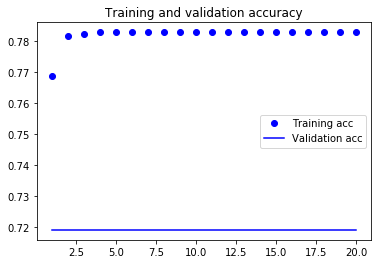

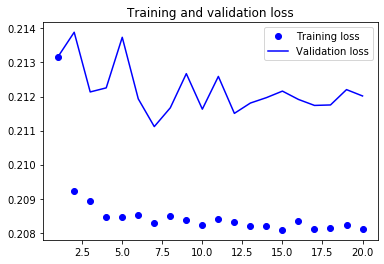

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
epochs = np.argmin(val_loss)
epochs

6

In [35]:
history = model.fit(data_train, label_train,
                    epochs=epochs,
                    batch_size=32)


Epoch 1/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2088 - acc: 0.7700
Epoch 2/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2087 - acc: 0.7700
Epoch 3/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2088 - acc: 0.7700
Epoch 4/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2088 - acc: 0.7700
Epoch 5/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2087 - acc: 0.7700
Epoch 6/6
1939/1939 [==============================] - 6s 3ms/step - loss: 0.2088 - acc: 0.7700


In [48]:
pred = model.predict(data_test)

In [49]:
pred.shape

(832, 7)

In [50]:
pred[:5]

array([[0.7550097 , 0.5348369 , 0.44674712, 0.6594564 , 0.13006642,
        0.31233552, 0.35518056],
       [0.7550097 , 0.5348369 , 0.44674712, 0.6594564 , 0.13006642,
        0.31233552, 0.35518056],
       [0.7550097 , 0.5348369 , 0.44674712, 0.6594564 , 0.13006642,
        0.31233552, 0.35518056],
       [0.7550097 , 0.5348369 , 0.44674712, 0.6594564 , 0.13006642,
        0.31233552, 0.35518056],
       [0.7550097 , 0.5348369 , 0.44674712, 0.6594564 , 0.13006642,
        0.31233552, 0.35518056]], dtype=float32)

In [51]:
label_test_predict = (pred >=.4) + 0

In [52]:
label_test_predict

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [53]:
label_test.sum(axis=0), label_test_predict.sum(axis=0)

(array([644, 414, 389, 548, 134, 262, 272]),
 array([832, 832, 832, 832,   0,   0,   0]))

In [54]:
y_test = label_test
result = label_test_predict

## predict

In [55]:
score_macro = f1_score(y_test, result, average="macro")
score_micro = f1_score(y_test, result, average="micro")
acc = accuracy_score(y_test, result)

score_1 = label_ranking_average_precision_score(y_test, result)
score_2 = label_ranking_loss(y_test, result)

print("F1_macro:{0}, F1_micro:{1}, accuracy:{1},".format(score_macro, score_micro, acc), score_1, score_2)

F1_macro:0.42407724953883263, F1_micro:0.6659989984977466, accuracy:0.6659989984977466, 0.595398351648353 0.4899238782051282


## test

In [60]:
random_result = np.zeros(y_test.shape)
random_result[:, 2] = 1

score_macro = f1_score(y_test, random_result, average="macro")
score_micro = f1_score(y_test, random_result, average="micro")
acc = accuracy_score(y_test, random_result)

score_1 = label_ranking_average_precision_score(y_test, random_result)
score_2 = label_ranking_loss(y_test, random_result)

print("F1_macro:{0}, F1_micro:{1}, accuracy:{1},".format(score_macro, score_micro, acc), score_1, score_2)

F1_macro:0.09102609102609104, F1_micro:0.22260371959942774, accuracy:0.22260371959942774, 0.5363095238095235 0.844871794871795


In [61]:
random_result = np.random.randint(2, size=y_test.shape)

score_macro = f1_score(y_test, random_result, average="macro")
score_micro = f1_score(y_test, random_result, average="micro")
acc = accuracy_score(y_test, random_result)

score_1 = label_ranking_average_precision_score(y_test, random_result)
score_2 = label_ranking_loss(y_test, random_result)

print("F1_macro:{0}, F1_micro:{1}, accuracy:{1},".format(score_macro, score_micro, acc), score_1, score_2)

F1_macro:0.44669301284633317, F1_micro:0.4731297982503124, accuracy:0.4731297982503124, 0.5041864125457871 0.7423076923076923


In [62]:
random_result = np.ones(y_test.shape)
random_result[:, 2] = 0

score_macro = f1_score(y_test, random_result, average="macro")
score_micro = f1_score(y_test, random_result, average="micro")
acc = accuracy_score(y_test, random_result)

score_1 = label_ranking_average_precision_score(y_test, random_result)
score_2 = label_ranking_loss(y_test, random_result)

print("F1_macro:{0}, F1_micro:{1}, accuracy:{1},".format(score_macro, score_micro, acc), score_1, score_2)

F1_macro:0.5115029541423678, F1_micro:0.5941214892227303, accuracy:0.5941214892227303, 0.47371413308913307 0.8522435897435897


In [63]:
random_result = np.ones(y_test.shape)


score_macro = f1_score(y_test, random_result, average="macro")
score_micro = f1_score(y_test, random_result, average="micro")
acc = accuracy_score(y_test, random_result)

score_1 = label_ranking_average_precision_score(y_test, random_result)
score_2 = label_ranking_loss(y_test, random_result)

print("F1_macro:{0}, F1_micro:{1}, accuracy:{1},".format(score_macro, score_micro, acc), score_1, score_2)

F1_macro:0.6025290451684588, F1_micro:0.6275480146105809, accuracy:0.6275480146105809, 0.4632554945054946 0.9831730769230769


## test

In [ ]:
1